# F1 Data Analysis

In [2]:
from utils.extract import F1DataProcessor
from utils.telemetry import F1TelemetryAnalyzer

%load_ext autoreload
%autoreload 2

## Extracting Qualifying Data

In [14]:
f1_processor = F1DataProcessor("cache", 2024)
quali_data, lap_data = f1_processor.get_quali_session(range(1,22))

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']
/Users/katecastillo/Documents/learning/f1-exploration/utils/extract.py:67: SettingWithCopyWarning: 
A value i

In [15]:
quali_data

,Event,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,FreshTyre,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,QualiSession,LapRank,CurrentFastestLap,DeltaFastestLap
54,2024 1,SAI,55,Ferrari,0 days 00:01:31.208000,2.0,1.0,29.760,38.878,22.570,...,True,1,False,,2024-03-01 16:02:03.438,2024-03-01 16:03:34.646,1.0,1.0,0 days 00:01:31.208000,0.000
18,2024 1,LEC,16,Ferrari,0 days 00:01:31.260000,2.0,1.0,29.522,39.009,22.729,...,True,1,False,,2024-03-01 16:02:12.510,2024-03-01 16:03:43.770,1.0,2.0,0 days 00:01:31.208000,0.052
250,2024 1,OCO,31,Alpine,0 days 00:01:31.990000,2.0,1.0,29.755,39.305,22.930,...,True,1,False,,2024-03-01 16:02:25.128,2024-03-01 16:03:57.118,1.0,3.0,0 days 00:01:31.208000,0.782
259,2024 1,GAS,10,Alpine,0 days 00:01:32.434000,2.0,1.0,29.870,39.498,23.066,...,True,1,True,TRACK LIMITS AT TURN 13 LAP 3,2024-03-01 16:02:32.131,2024-03-01 16:04:04.565,1.0,4.0,0 days 00:01:31.208000,1.226
196,2024 1,ALB,23,Williams,0 days 00:01:30.692000,2.0,1.0,29.194,38.750,22.748,...,True,1,False,,2024-03-01 16:07:17.366,2024-03-01 16:08:48.058,1.0,1.0,0 days 00:01:30.692000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2024 21,TSU,22,RB,0 days 00:01:24.111000,29.0,8.0,21.510,44.415,18.186,...,True,1,False,,2024-11-03 12:10:46.850,2024-11-03 12:12:10.961,3.0,2.0,0 days 00:01:24.092000,0.019
121,2024 21,OCO,31,Alpine,0 days 00:01:24.475000,30.0,8.0,21.545,44.500,18.430,...,True,1,False,,2024-11-03 12:10:55.961,2024-11-03 12:12:20.436,3.0,4.0,0 days 00:01:24.092000,0.383
31,2024 21,NOR,4,McLaren,0 days 00:01:23.405000,32.0,8.0,21.639,43.807,17.959,...,True,1,False,,2024-11-03 12:11:07.320,2024-11-03 12:12:30.725,3.0,1.0,0 days 00:01:23.405000,0.000
60,2024 21,RUS,63,Mercedes,0 days 00:01:23.578000,28.0,8.0,21.463,44.025,18.090,...,True,1,False,,2024-11-03 12:11:21.578,2024-11-03 12:12:45.156,3.0,2.0,0 days 00:01:23.405000,0.173


In [16]:
lap_data

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance,LapNumber,CumulativeDistance,Driver,Event
0,2024-03-01 16:08:56.760,10645,297,7,100,0,12,car,0 days 00:00:00.107000,0 days 00:22:21.087000,8.827500,1,0.000000,VER,2024 1
1,2024-03-01 16:08:56.920,10674,299,8,100,0,12,car,0 days 00:00:00.267000,0 days 00:22:21.247000,22.116389,1,13.288889,VER,2024 1
2,2024-03-01 16:08:57.120,10747,301,8,100,0,12,car,0 days 00:00:00.467000,0 days 00:22:21.447000,38.838611,1,43.300000,VER,2024 1
3,2024-03-01 16:08:57.280,10785,303,8,100,0,12,car,0 days 00:00:00.627000,0 days 00:22:21.607000,52.305278,1,86.777778,VER,2024 1
4,2024-03-01 16:08:57.441,10850,305,8,100,0,12,car,0 days 00:00:00.788000,0 days 00:22:21.768000,65.945556,1,143.895833,VER,2024 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529,2024-11-03 10:57:09.022,11618,292,7,100,0,9,car,0 days 00:24:37.945000,0 days 00:42:06.907000,42506.542778,8,699302.730000,ZHO,2024 21
5530,2024-11-03 10:57:09.342,11617,294,7,100,0,9,car,0 days 00:24:38.265000,0 days 00:42:07.227000,42532.676111,8,703461.113056,ZHO,2024 21
5531,2024-11-03 10:57:09.622,11645,293,7,100,0,9,car,0 days 00:24:38.545000,0 days 00:42:07.507000,42555.465000,8,707642.285000,ZHO,2024 21
5532,2024-11-03 10:57:10.022,11654,294,7,100,0,9,car,0 days 00:24:38.945000,0 days 00:42:07.907000,42588.131667,8,711856.123611,ZHO,2024 21


/Users/katecastillo/Documents/learning/f1-exploration/utils/telemetry.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


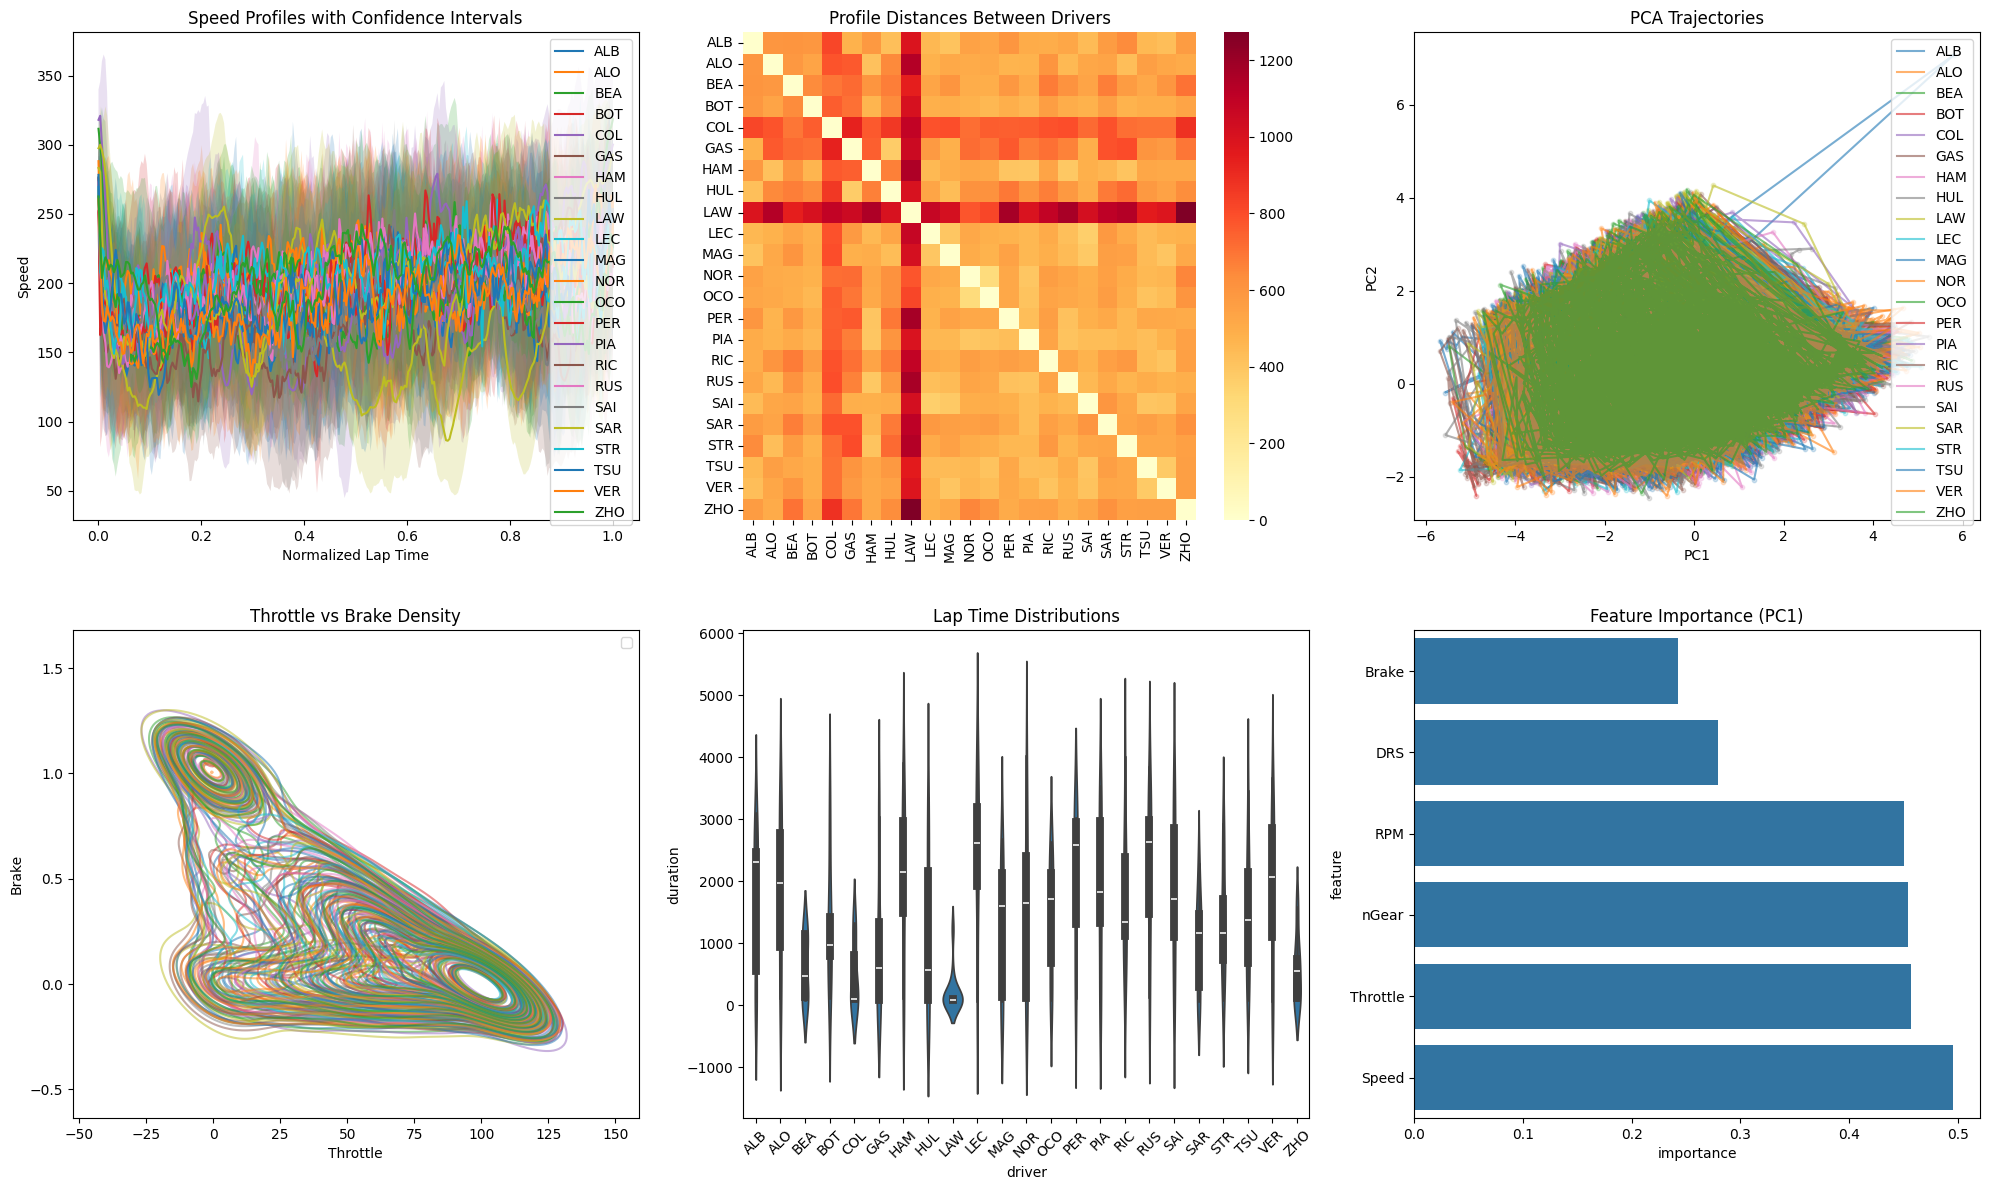

In [29]:
analyzer = F1TelemetryAnalyzer(n_samples=300)  # Set fixed number of samples per lap
results = analyzer.analyze_laps(lap_data)

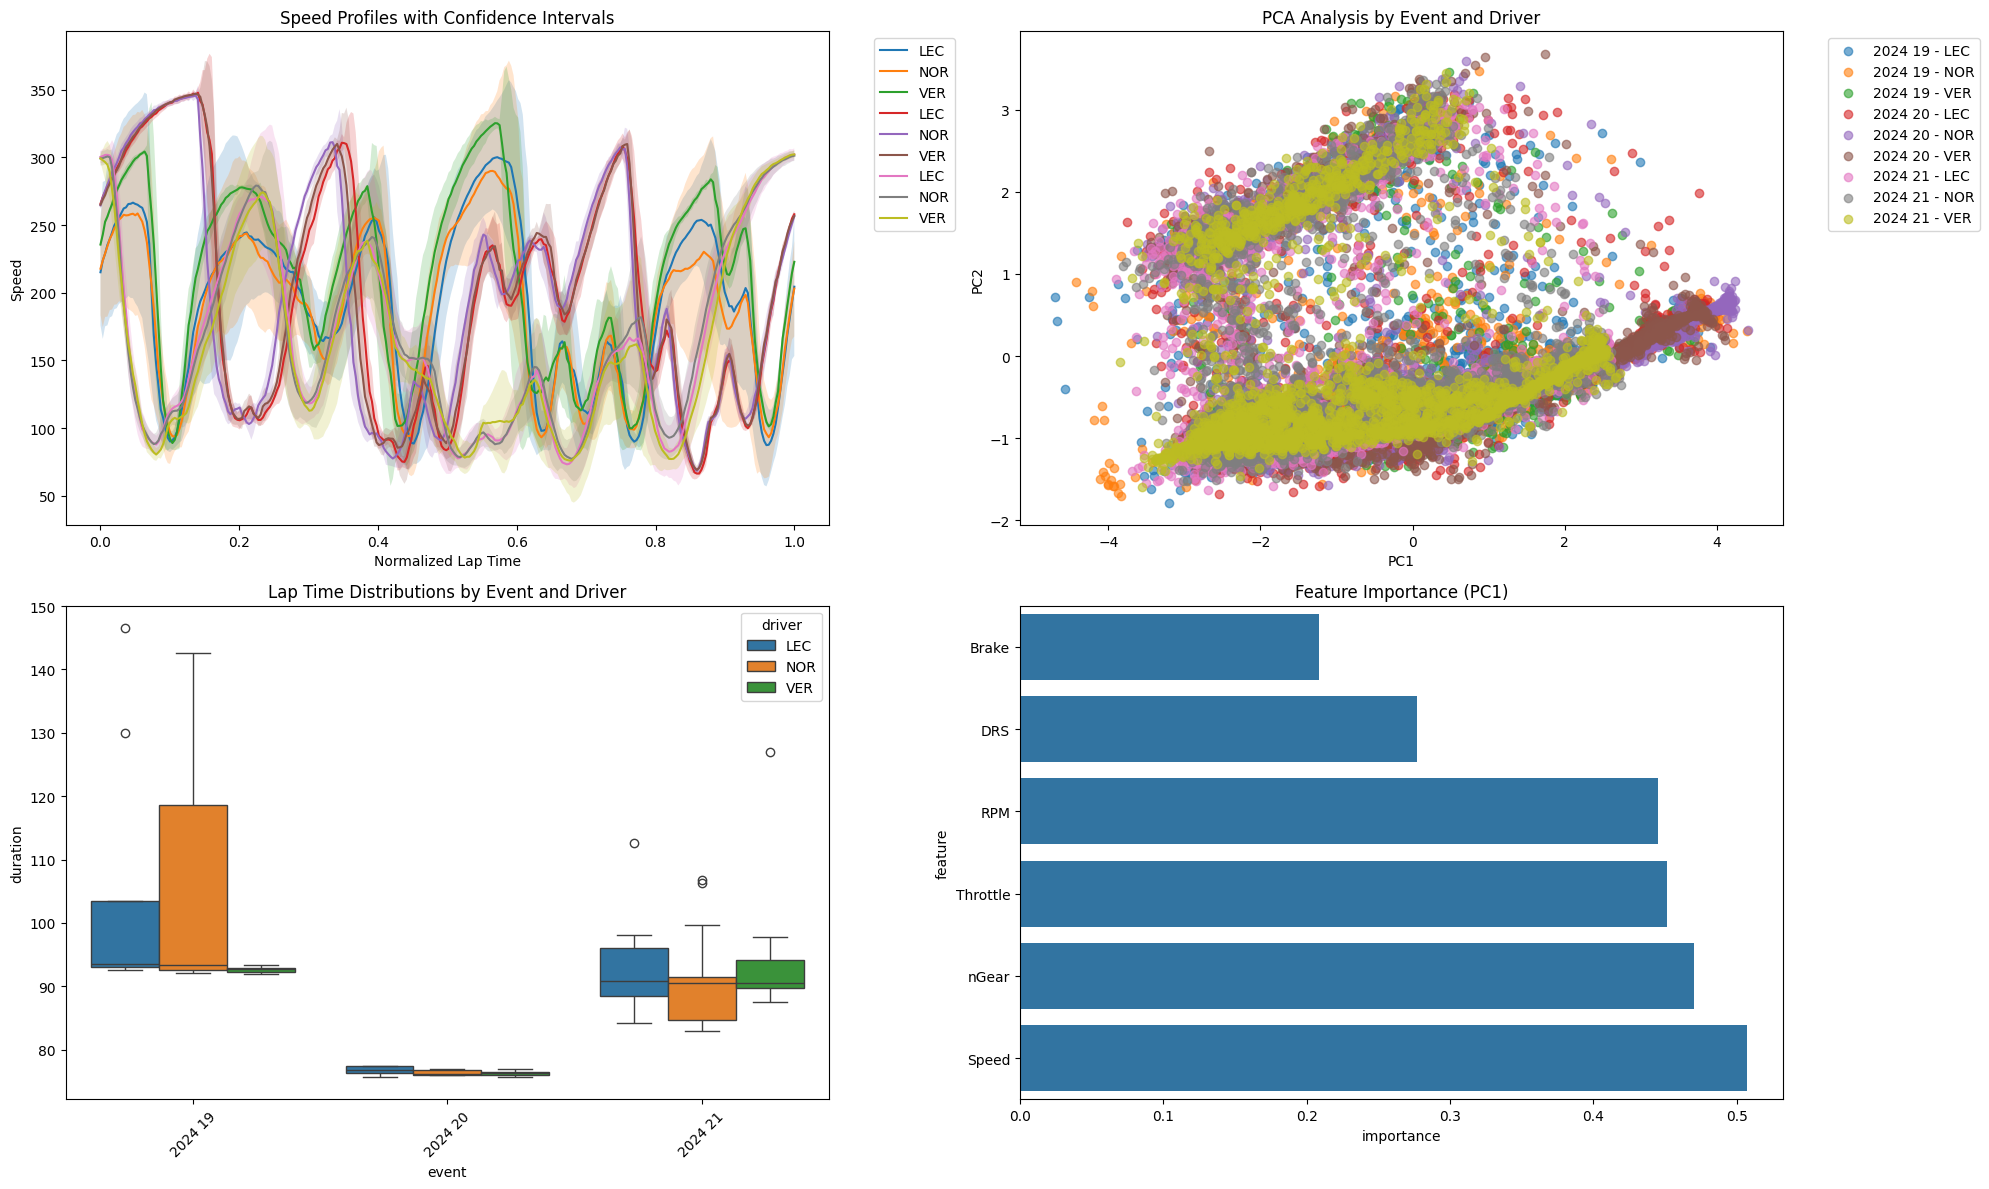

In [ ]:
results = analyzer.analyze_laps(
    lap_data,
    events=["2024 19", "2024 20", "2024 21"],
    drivers=["VER", "NOR", "LEC"]
)

## Extracting Race Data

In [32]:
race_data, lap_data = f1_processor.get_race_session(range(19,22))

core           INFO 	Loading data for United States Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
/Users/katecastillo/Documents/learning/f1-exploration/

In [33]:
race_data

,Event,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate
0,2024 19,VER,1,Red Bull Racing,0 days 00:01:41.657000,1.0,1.0,NaN,40.291,33.295,...,312.0,False,MEDIUM,1.0,True,12,False,,2024-10-20 19:03:48.551,2024-10-20 19:05:30.208
1,2024 19,VER,1,Red Bull Racing,0 days 00:01:39.991000,2.0,1.0,26.845,39.996,33.150,...,306.0,True,MEDIUM,2.0,True,1,False,,2024-10-20 19:05:30.540,2024-10-20 19:07:10.531
2,2024 19,VER,1,Red Bull Racing,0 days 00:02:02.849000,3.0,1.0,26.980,46.144,49.725,...,183.0,False,MEDIUM,3.0,True,124,False,,2024-10-20 19:07:10.531,2024-10-20 19:09:13.380
3,2024 19,VER,1,Red Bull Racing,NaT,4.0,1.0,40.222,58.115,53.159,...,205.0,False,MEDIUM,4.0,True,4,False,,2024-10-20 19:09:13.380,NaT
4,2024 19,VER,1,Red Bull Racing,NaT,5.0,1.0,40.279,61.864,65.480,...,130.0,False,MEDIUM,5.0,True,41,False,,2024-10-20 19:11:44.919,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2024 21,PIA,81,McLaren,0 days 00:01:21.840000,65.0,3.0,20.784,43.137,17.919,...,277.0,False,INTERMEDIATE,35.0,False,1,False,,2024-11-03 17:50:37.939,2024-11-03 17:51:59.779
1131,2024 21,PIA,81,McLaren,0 days 00:01:21.884000,66.0,3.0,20.864,43.215,17.805,...,275.0,False,INTERMEDIATE,36.0,False,1,False,,2024-11-03 17:51:59.779,2024-11-03 17:53:21.663
1132,2024 21,PIA,81,McLaren,0 days 00:01:22.286000,67.0,3.0,21.336,43.159,17.791,...,276.0,False,INTERMEDIATE,37.0,False,1,False,,2024-11-03 17:53:21.663,2024-11-03 17:54:43.949
1133,2024 21,PIA,81,McLaren,0 days 00:01:21.719000,68.0,3.0,20.873,42.918,17.928,...,270.0,True,INTERMEDIATE,38.0,False,1,False,,2024-11-03 17:54:43.949,2024-11-03 17:56:05.668


In [34]:
lap_data

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance,LapNumber,CumulativeDistance,Driver,Event
0,2024-10-20 19:03:48.560,9943,0,1,16,1,1,car,0 days 00:00:00.009000,0 days 00:57:10.962000,0.000000,1,0.000000,VER,2024 19
1,2024-10-20 19:03:48.800,10050,0,1,16,1,1,car,0 days 00:00:00.249000,0 days 00:57:11.202000,0.000000,1,0.000000,VER,2024 19
2,2024-10-20 19:03:49.000,10017,0,1,16,0,1,car,0 days 00:00:00.449000,0 days 00:57:11.402000,0.000000,1,0.000000,VER,2024 19
3,2024-10-20 19:03:49.200,8617,7,1,16,0,1,car,0 days 00:00:00.649000,0 days 00:57:11.602000,0.388889,1,0.388889,VER,2024 19
4,2024-10-20 19:03:49.360,7497,7,1,16,0,1,car,0 days 00:00:00.809000,0 days 00:57:11.762000,0.700000,1,1.088889,VER,2024 19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28571,2024-11-03 17:57:26.132,10841,310,8,99,0,1,car,0 days 02:07:28.616000,0 days 03:19:23.386000,292761.490833,69,527212.923056,PIA,2024 21
28572,2024-11-03 17:57:26.412,10838,310,8,99,0,1,car,0 days 02:07:28.896000,0 days 03:19:23.666000,292785.601944,69,531086.921389,PIA,2024 21
28573,2024-11-03 17:57:26.572,10857,311,8,99,0,1,car,0 days 02:07:29.056000,0 days 03:19:23.826000,292799.424167,69,534974.741944,PIA,2024 21
28574,2024-11-03 17:57:26.811,10857,311,8,99,0,1,car,0 days 02:07:29.295000,0 days 03:19:24.065000,292820.071111,69,538883.209444,PIA,2024 21


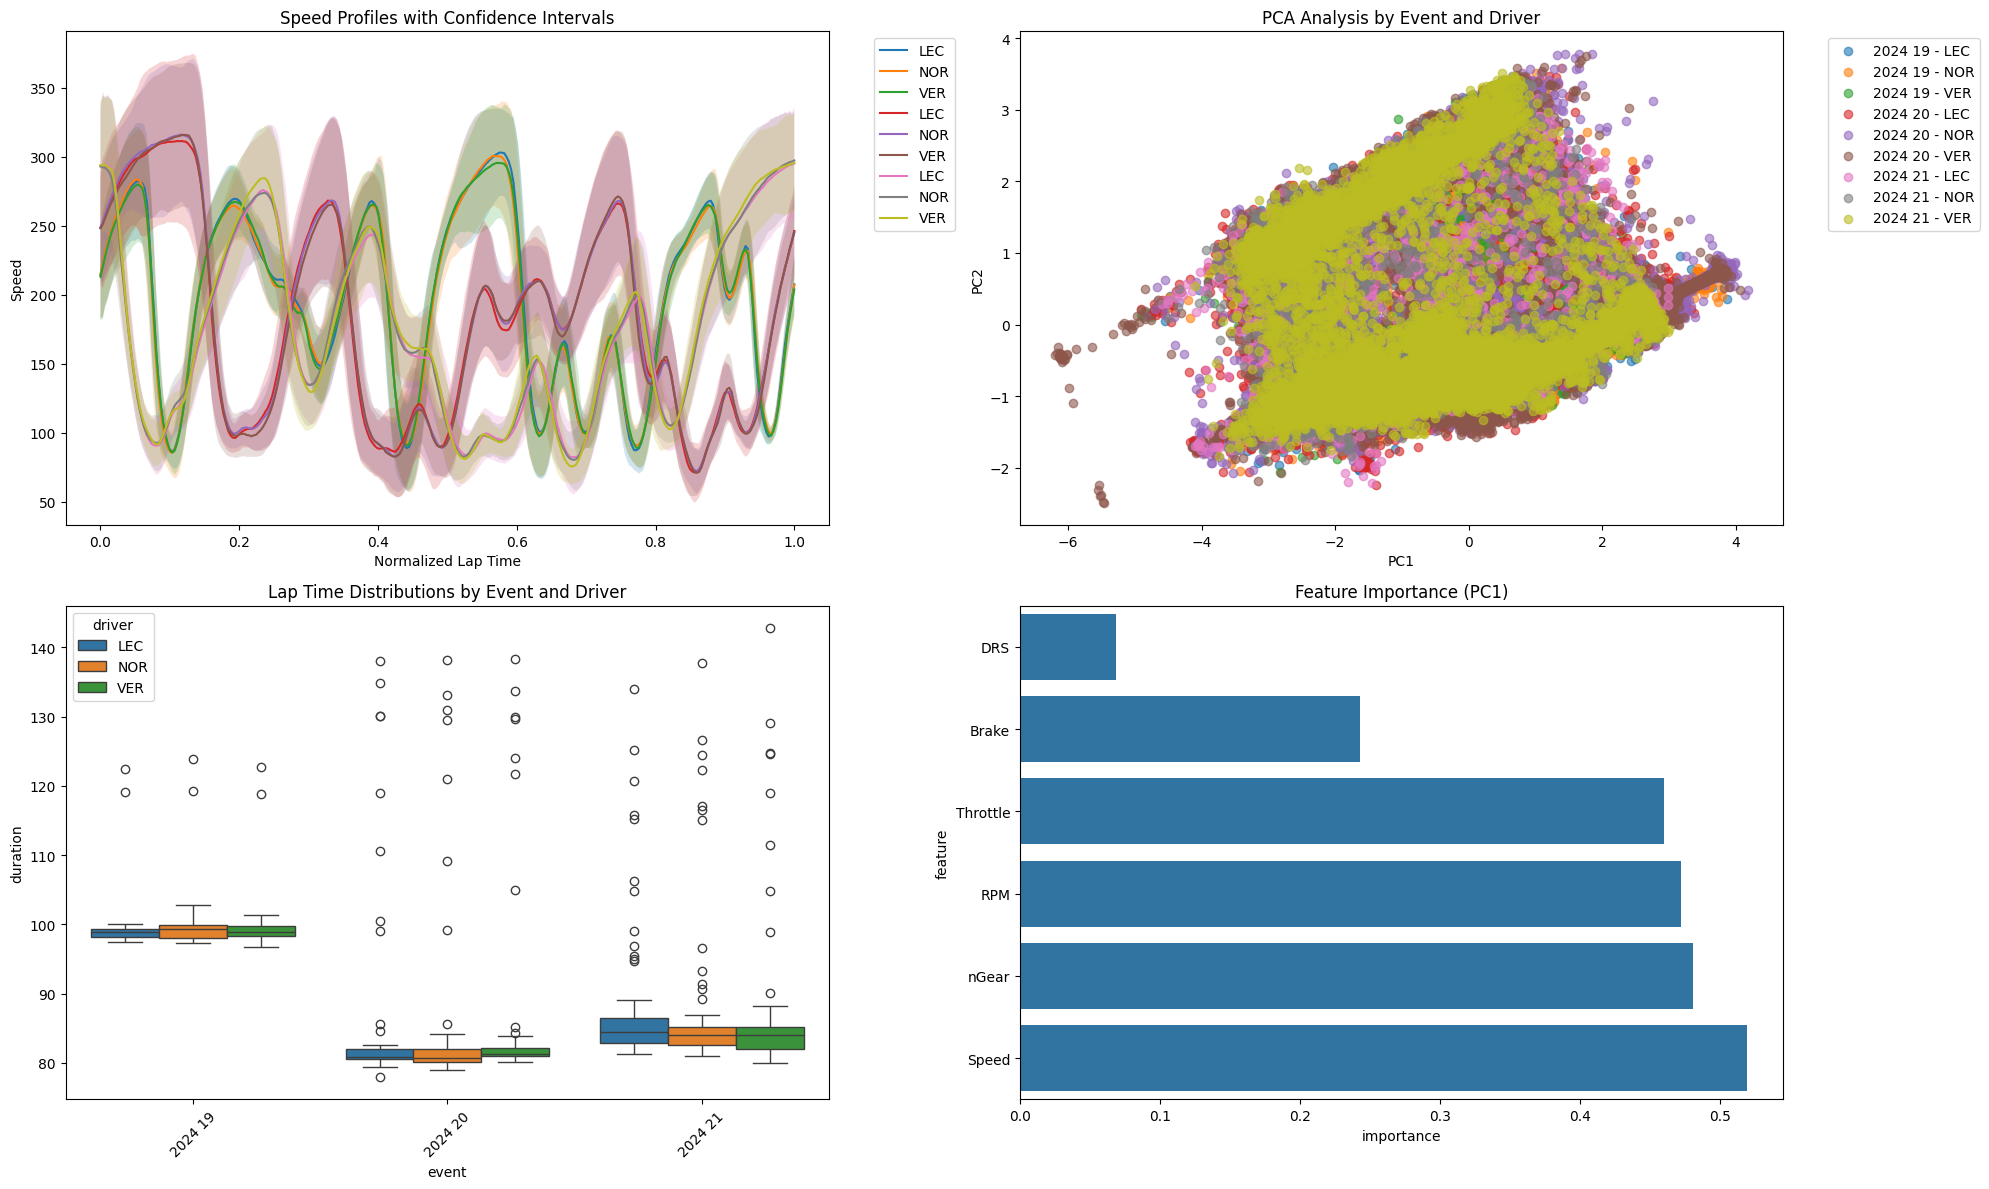

In [35]:
results = analyzer.analyze_laps(
    lap_data,
    events=["2024 19", "2024 20", "2024 21"],
    drivers=["VER", "NOR", "LEC"]
)